#### Imports

In [2]:
# Basic imports & versions
import sys, os, json, time, copy, csv, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger, DiscretizeActionWrapper, PowerScaledDiscreteActions
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-10-15 23:51:56.108322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 23:51:56.121965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760565116.137426 4004902 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760565116.141803 4004902 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760565116.153473 4004902 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


#### Variables

In [3]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ACTION_LABELS = ['discharge_full', 'discharge_half', 'idle', 'charge_half', 'charge_full']
ONLY_ELECTRICAL_STORAGE = True
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)

EVAL_EPISODES = 10
TRAIN_EPISODES = 50
TIMESTEPS_PER_TRAIN_EPISODE = 1463

# Training and Evaluation files
TRAINING_FILE = os.path.join(LOG_DIR, "ppo_split_50train_final") # xxx
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "ppo_split_50train_steps_final.csv") # xxx
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "ppo_split_50train_episodes_final.csv") # xxx
EVAL_FILE = os.path.join(LOG_DIR, "ppo_split_10eval_final_not_deterministic.pkl") # xxx

MONTH_SLICES = {
    "train": (0, 1463),     # train: june - july
    "test": (1464, 2207),   # test: august
}


In [4]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN 

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


#### Logger

In [5]:
class TrainStepCSVLogger(BaseCallback):
    """
    Step-wise CSV logger for SB3 (works with PPO, A2C, etc., and with VecEnvs/Monitor).
    - Writes rows: [step, env_id, episode, action_id, action_label, action_frac, reward]
    - Robust action extraction: tries info[...] first, then raw action; can quantize to the nearest allowed fraction.
    - Keeps episode counters per env_id.
    - After training, exposes:
        self.df     -> pandas.DataFrame of all step rows
        self.ep_df  -> pandas.DataFrame aggregated by episode (return, length) per env
    """
    def __init__(
        self,
        save_dir="logs/ppo",
        filename="train_steps.csv",
        action_labels=None,   
        action_fracs=None,  
        flush_every_steps=5000,
        verbose=0
    ):
        super().__init__(verbose)
        self.save_dir = save_dir
        self.filepath = os.path.join(save_dir, filename)
        self.action_labels = list(action_labels) if action_labels is not None else None
        self.action_fracs = np.asarray(action_fracs, dtype=float) if action_fracs is not None else None
        self.flush_every_steps = int(flush_every_steps)

        # runtime state
        self._fh = None
        self._writer = None
        self._rows = []
        self._t0 = None
        self._ep_counters = None
        self.df = None
        self.ep_df = None

    # ---------- helpers ----------
    @staticmethod
    def _unwrap_to_citylearn(env):
        cur, seen = env, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        return None

    def _get_citylearn_env_for_idx(self, idx: int):
        # DummyVecEnv hat .envs, SubprocVecEnv nutzt env_method/get_attr, aber hier meist DummyVecEnv.
        venv = self.training_env
        base = None
        if hasattr(venv, "envs"):                 # DummyVecEnv
            base = self._unwrap_to_citylearn(venv.envs[idx])
        else:
            try:
                base = self._unwrap_to_citylearn(venv.get_attr("env")[idx])
            except Exception:
                base = None
        return base

    # ---- lifecycle hooks ----
    def _on_training_start(self) -> None:
        os.makedirs(self.save_dir, exist_ok=True)
        self._t0 = time.time()
        n_envs = int(getattr(self.training_env, "num_envs", 1))
        self._current_ep_counts = [0]*n_envs

        new_file = not os.path.exists(self.filepath) or os.path.getsize(self.filepath) == 0
        self._fh = open(self.filepath, "a", newline="")
        self._writer = csv.writer(self._fh)
        if new_file:
            self._writer.writerow([
                # meta
                "global_step","time_sec","env_id","episode",
                # action + reward
                "action_id","action_label","action_frac","reward",
                # CityLearn internals (t-1; konsistent mit obs)
                "price","net_load","non_shiftable_load","cooling_load","heating_load","dhw_load",
                "chargers_load","storage_load","solar","battery_soc","battery_energy_balance",
                "simulate_power_outage","power_outage"
            ])
            self._fh.flush()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        infos   = self.locals.get("infos", [])
        step    = int(self.num_timesteps)

        n_envs = len(rews) if hasattr(rews, "__len__") else 1
        for idx in range(n_envs):
            act  = acts[idx] if hasattr(acts, "__len__") else acts
            rew  = rews[idx] if hasattr(rews, "__len__") else rews
            done = bool(dones[idx]) if hasattr(dones, "__len__") else bool(dones)

            # Extract discrete action ID
            try:
                a_id = int(act) if np.isscalar(act) else int(np.array(act).reshape(-1)[0])
            except Exception:
                a_id = None

            # Label & Frac
            a_label = (self.action_labels[a_id] if (a_id is not None and 0 <= a_id < len(self.action_labels)) else None)
            a_frac  = (float(self.action_fracs[a_id]) if (a_id is not None and 0 <= a_id < len(self.action_fracs)) else None)

            row = {
                "global_step": step,
                "time_sec": f"{time.time()-self._t0:.3f}",
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": (a_id if a_id is not None else ""),
                "action_label": a_label if a_label is not None else "",
                "action_frac": f"{a_frac:.1f}" if a_frac is not None else "",
                "reward": f"{float(rew):.6f}",
                # CityLearn Felder folgen, evtl. leer
                "price": "", "net_load": "", "non_shiftable_load": "",
                "cooling_load": "", "heating_load": "", "dhw_load": "",
                "chargers_load": "", "storage_load": "", "solar": "",
                "battery_soc": "", "battery_energy_balance": "",
                "simulate_power_outage": "", "power_outage": ""
            }

            # CityLearn-Interna (t-1 = consistent to obs)
            try:
                base = self._get_citylearn_env_for_idx(idx)
                if base is not None and len(base.buildings) > 0:
                    b = base.buildings[0]
                    t  = int(getattr(b, "time_step", 0))
                    tp = max(0, t-1)

                    chargers_arr = getattr(b, "_Building__chargers_electricity_consumption", None)
                    chargers_tp  = float(chargers_arr[tp]) if chargers_arr is not None else np.nan

                    row.update({
                        "price": float(b.pricing.electricity_pricing[tp]),
                        "net_load": float(b.net_electricity_consumption[tp]),
                        "non_shiftable_load": float(b.non_shiftable_load_device.electricity_consumption[tp]),
                        "cooling_load": float(b.cooling_device.electricity_consumption[tp]),
                        "heating_load": float(b.heating_device.electricity_consumption[tp]),
                        "dhw_load": float(b.dhw_device.electricity_consumption[tp]),
                        "chargers_load": chargers_tp,
                        "storage_load": float(b.electrical_storage.electricity_consumption[tp]),
                        "solar": float(b.solar_generation[tp]),
                        "battery_soc": float(b.electrical_storage.soc[tp]),
                        "battery_energy_balance": float(b.electrical_storage.energy_balance[tp]),
                        "simulate_power_outage": bool(getattr(b, 'simulate_power_outage', False)),
                        "power_outage": bool(getattr(b, 'power_outage', False)),
                    })
            except Exception:
                pass

            row_df = {
                "global_step": step,
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": a_id if a_id is not None else None,
                "action_label": a_label if a_label is not None else None,
                "action_frac": float(a_frac) if a_frac is not None else None,
                "reward": float(rew),
                "price": row["price"] if row["price"] != "" else None,
                "net_load": row["net_load"] if row["net_load"] != "" else None,
                "non_shiftable_load": row["non_shiftable_load"] if row["non_shiftable_load"] != "" else None,
                "cooling_load": row["cooling_load"] if row["cooling_load"] != "" else None,
                "heating_load": row["heating_load"] if row["heating_load"] != "" else None,
                "dhw_load": row["dhw_load"] if row["dhw_load"] != "" else None,
                "chargers_load": row["chargers_load"] if row["chargers_load"] != "" else None,
                "storage_load": row["storage_load"] if row["storage_load"] != "" else None,
                "solar": row["solar"] if row["solar"] != "" else None,
                "battery_soc": row["battery_soc"] if row["battery_soc"] != "" else None,
                "battery_energy_balance": row["battery_energy_balance"] if row["battery_energy_balance"] != "" else None,
            }
            self._rows.append(row_df)


            # write CSV row
            self._writer.writerow([
                row["global_step"], row["time_sec"], row["env_id"], row["episode"],
                row["action_id"], row["action_label"], row["action_frac"], row["reward"],
                row["price"], row["net_load"], row["non_shiftable_load"], row["cooling_load"], row["heating_load"],
                row["dhw_load"], row["chargers_load"], row["storage_load"], row["solar"],
                row["battery_soc"], row["battery_energy_balance"],
                row["simulate_power_outage"], row["power_outage"]
            ])

            if done:
                self._current_ep_counts[idx] += 1

        if self.flush_every_steps and (self.num_timesteps % self.flush_every_steps == 0):
            self._fh.flush()
        return True

    def _on_training_end(self) -> None:
        if self._fh is not None:
            self._fh.flush()
            self._fh.close()
            self._fh = None
            self._writer = None
        if self._rows:
            self.df = pd.DataFrame(self._rows)
            self.ep_df = (self.df.groupby(["env_id","episode"], as_index=False)
                            .agg(ep_return=("reward","sum"),
                                ep_length=("reward","size")))

#### Training

In [7]:
def compute_action_scales(cl_env, alpha=0.8):
    """scale = alpha * (P_nom * dt / capacity). alpha<1 provides headroom -> less clipping.
    P_nom: nominal power of storage (kW)
    capacity: energy capacity of storage (kWh)
    dt: time step duration (h)"""
    dt_h = cl_env.schema['seconds_per_time_step'] / 3600.0
    scales = []
    for b in cl_env.buildings:
        cap  = max(b.electrical_storage.capacity, 1e-9)   # kWh
        pnom = b.electrical_storage.nominal_power         # kW
        scales.append(alpha * (pnom * dt_h) / cap)
    return np.array(scales, dtype=np.float32)

# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")


# ---- Define train test split ----
train_start, train_end = MONTH_SLICES["train"]
test_start, test_end = MONTH_SLICES["test"]


# --- Build TRAIN env ---
schema_train = dict(schema_1b)
train_env = CityLearnEnv(schema_train, central_agent=True)

scales = compute_action_scales(train_env)

train_env = NormalizedObservationWrapper(train_env)
train_env = StableBaselines3Wrapper(train_env)
train_env = PowerScaledDiscreteActions(train_env, scales=scales)
train_env = Monitor(train_env, filename=os.path.join(LOG_DIR, "monitor.csv"))

#train_callback = PPOTrainLogger()
train_callback = TrainStepCSVLogger(
    save_dir=LOG_DIR,
    filename="ppo_split_train_steps_final.csv",
    action_labels=ACTION_LABELS,    
    action_fracs=INT_TO_FRAC
)

TOTAL_TIMESTEPS = TRAIN_EPISODES * TIMESTEPS_PER_TRAIN_EPISODE

# Best parameters found by optuna
model = PPO(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    learning_rate=0.00284168226539535,
    gamma=0.971587814014358,
    ent_coef=0.05885182459088836,
    vf_coef=0.9901724232320459,
    gae_lambda=0.884166238447603,
    n_steps=64,
    batch_size=128,
    n_epochs=8,
    clip_range=0.21369082195658376,
    verbose=1,
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU),
    device='cpu',
)

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-15_23-52-41'
Using cpu device
Wrapping the env in a DummyVecEnv.


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 64`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 64
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=1)
  warnings.warn(


##### View action space

In [ ]:
print("Action space:", env.action_space)
print("Action scales (pro Building):", scales)
print('Train action_space:', train_env.action_space)

##### View initilization

In [4]:
# check initialization
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Action_space [Box(low_limit, high_limit), shape, datatype]:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space [Box(low_limit, high_limit), shape, datatype]: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


##### Run Training

In [7]:
# ca 100min
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)  
print(f"PPO model saved to {os.path.abspath(TRAINING_FILE)}")

print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs
train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

----------------------------
| time/              |     |
|    fps             | 120 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 107        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 128        |
| train/                  |            |
|    approx_kl            | 0.03391163 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.214      |
|    entropy_loss         | -1.59      |
|    explained_variance   | -0.0141    |
|    learning_rate        | 0.00284    |
|    loss                 | -0.103     |
|    n_updates            | 8          |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.0851     |
----------------------------------------
-----------------------------------------
| time/          

##### View first and last mean return (is model learning?)

In [6]:
# Quick learning check on training episodes
if hasattr(train_callback, 'ep_df') and len(train_callback.ep_df):
    ep_df = train_callback.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['ep_return'].head(first_n).mean()
    last_mean  = ep_df['ep_return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in train_callback.ep_df')

TypeError: object of type 'NoneType' has no len()

#### Evaluation

In [8]:
schema_test = dict(schema_1b)
schema_eval = copy.deepcopy(schema_test)
eval_env = CityLearnEnv(schema_eval, 
                        central_agent=True,
                        simulation_start_time_step=test_start,    
                        simulation_end_time_step=test_end)
eval_scales = compute_action_scales(eval_env)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = PowerScaledDiscreteActions(eval_env, scales=eval_scales)

model = PPO.load(TRAINING_FILE)
print(f"PPO model loaded from {os.path.abspath(TRAINING_FILE)}")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-15_23-52-51'
PPO model loaded from /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_split_50train_final


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


##### View action space & scales

In [ ]:
print("Eval action scales:", eval_scales)
print('Eval action_space:', eval_env.action_space)

##### Run Evaluation

In [9]:
# Set eval episodes on top of the notebook
def evaluate_with_metrics(model, env, episodes=EVAL_EPISODES, deterministic=True, render=False, save_path=EVAL_FILE, seeds=None):
    """
    Wie zuvor, plus: pro Episode optional eigener Seed.
    seeds:
      - None -> [10000 + i for i in range(episodes)]
      - int  -> Basis-Seed; Episoden-Seeds = base + i
      - list/array mit Länge 'episodes'
    """

    # --- Seeds vorbereiten
    if seeds is None:
        seeds = [10000 + i for i in range(episodes)]
    elif isinstance(seeds, (int, np.integer)):
        seeds = [int(seeds) + i for i in range(episodes)]
    else:
        seeds = list(map(int, seeds))
        assert len(seeds) == episodes, "len(seeds) muss == episodes sein"


    def set_random_soc_after_reset(base_env, building_index, low=0.20, high=0.80, rng=None):
        """Nach env.reset() aufrufen. Setzt den Start-SoC für die Episode."""
        if rng is None:
            rng = np.random.default_rng()
        soc0 = float(rng.uniform(low, high))
        b = base_env.buildings[building_index]
        # CityLearn: SoC am ersten Schritt verfügbar unter electrical_storage.soc[0]
        b.electrical_storage.soc[0] = np.clip(soc0, 0.0, 1.0)
        return soc0


    def _reset_with_seed(e, seed):
        try:
            return e.reset(seed=seed)
        except TypeError:
            # Fallback für ältere Wrapper
            try:
                if hasattr(e, "seed"):
                    e.seed(seed)
                return e.reset()
            except Exception:
                return e.reset()

    def action_to_frac(env, action):
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            return np.asarray(action, dtype=np.float32)

    def _get_base_env(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(env)
    bld_names = [b.name for b in base.buildings]
    building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    obs_names = getattr(base, "observation_names", None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get("net_electricity_consumption") \
            if "net_electricity_consumption" in name_to_idx else name_to_idx.get("net_electricity_consumption_without_storage")
    if i_net is None:
        i_net = name_to_idx.get("net_electricity_consumption_without_storage")
    i_nsl   = name_to_idx.get("non_shiftable_load")
    i_price = name_to_idx.get("electricity_pricing")
    i_solar = name_to_idx.get("solar_generation")

    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    ep_lengths = []
    actions_disc_list, ep_action_fracs = [], []
    ep_rewards_list = []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    t_global_start = time.time()

    for ep in range(1, episodes + 1):
        seed = seeds[ep - 1]
        obs, _ = _reset_with_seed(env, seed)

        _ = set_random_soc_after_reset(base, b_idx, low=0.20, high=0.80)

        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        last_info = None

        ep_actions_disc = []
        ep_fracs = []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)  # PPO hat predict()
            frac = action_to_frac(env, action)
            action_list.append(frac)

            obs, r, terminated, truncated, info = env.step(action)
            last_info = info
            done = bool(terminated or truncated)

            # zentraler Agent: r kann Sequenz sein -> zu float reduzieren
            r_float = float(np.asarray(r).mean())
            # optional: Monitor-Check
            if isinstance(last_info, dict) and 'episode' in last_info:
                # nicht alle Envs füllen das; nur sanity, kein Hard-Fail
                pass

            if isinstance(env.action_space, gym.spaces.Discrete):
                a_id = int(action)
            else:
                a_id = int(np.argmin(np.abs(INT_TO_FRAC - float(frac[0]))))

            ep_actions_disc.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            step_rewards.append(r_float)
            ep_ret += r_float
            ep_len += 1

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep,
            'seed': seed,                              # <<— Seed speichern
            'cumulative reward': ep_ret,
            'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec,
            'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)

        ep_lengths.append(ep_len)
        actions_disc_list.append(np.asarray(ep_actions_disc, dtype=int))
        ep_action_fracs.append(np.asarray(ep_fracs, dtype=float))
        ep_rewards_list.append(np.asarray(step_rewards, dtype=float))
        ep_net_load.append(np.asarray(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.asarray(ep_nsl, dtype=float))
        ep_price.append(np.asarray(ep_prc, dtype=float))
        ep_solar_generation.append(np.asarray(ep_sol, dtype=float))

        print(f"[Eval] Ep {ep}/{episodes} seed={seed} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    total_t = time.time() - t_global_start
    print(f"Total eval time: {total_t:.2f}s  | Avg/ep: {total_t/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)

    # Meta an DQN-Format angelehnt
    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    results = {
        'ep_lengths': np.asarray(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.asarray(all_step_rewards, dtype=float),

        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,

        'metrics_df': metrics_df,
        'episode_kpis': all_kpis,
        'eval_seeds': np.array(seeds, dtype=int),     # <<— Seeds mit abspeichern
    }
    print(f"Eval results: {list(results.keys())}")
    if save_path is not None:
        tmp = save_path + ".tmp"
        with open(tmp, "wb") as f:
            pickle.dump(results, f)
        os.replace(tmp, save_path)
        print(f"PPO eval results saved to {os.path.abspath(save_path)}")

    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

EVAL_SEEDS = [10000 + i for i in range(EVAL_EPISODES)]

metrics_det, step_rewards_det, kpis_det, actions_det = evaluate_with_metrics(
    model, eval_env,
    episodes=EVAL_EPISODES,
    deterministic=False,    
    save_path=EVAL_FILE,
    seeds=EVAL_SEEDS   
)

[Eval] Ep 1/10 seed=10000 return=-109.747 len=743 mean=-0.148 time=46.91s speed=15.8 steps/s
[Eval] Ep 2/10 seed=10001 return=-110.047 len=743 mean=-0.148 time=46.98s speed=15.8 steps/s
[Eval] Ep 3/10 seed=10002 return=-110.115 len=743 mean=-0.148 time=49.23s speed=15.1 steps/s
[Eval] Ep 4/10 seed=10003 return=-109.908 len=743 mean=-0.148 time=47.23s speed=15.7 steps/s
[Eval] Ep 5/10 seed=10004 return=-110.459 len=743 mean=-0.149 time=36.21s speed=20.5 steps/s
[Eval] Ep 6/10 seed=10005 return=-110.274 len=743 mean=-0.148 time=31.60s speed=23.5 steps/s
[Eval] Ep 7/10 seed=10006 return=-110.214 len=743 mean=-0.148 time=31.56s speed=23.5 steps/s
[Eval] Ep 8/10 seed=10007 return=-109.766 len=743 mean=-0.148 time=31.54s speed=23.6 steps/s
[Eval] Ep 9/10 seed=10008 return=-110.209 len=743 mean=-0.148 time=31.57s speed=23.5 steps/s
[Eval] Ep 10/10 seed=10009 return=-109.977 len=743 mean=-0.148 time=31.59s speed=23.5 steps/s
Total eval time: 384.57s  | Avg/ep: 38.46s


,episode,seed,cumulative reward,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,wall_time_s
0,1,10000,-109.747241,743,-0.147708,-1.757477,0.147919,0.169772,15.840450,46.905232
1,2,10001,-110.047481,743,-0.148112,-1.757477,0.118710,0.168849,15.815456,46.979361
2,3,10002,-110.114559,743,-0.148203,-1.757477,0.075461,0.169268,15.092526,49.229665
3,4,10003,-109.908203,743,-0.147925,-1.757477,0.159877,0.167285,15.731729,47.229392
4,5,10004,-110.458859,743,-0.148666,-1.757477,0.212660,0.171222,20.516432,36.214874
5,6,10005,-110.273703,743,-0.148417,-1.757477,0.151211,0.170004,23.513087,31.599424
6,7,10006,-110.214375,743,-0.148337,-1.559144,0.073526,0.166644,23.543986,31.557953
7,8,10007,-109.766255,743,-0.147734,-1.757477,0.248383,0.170977,23.557756,31.539507
8,9,10008,-110.209486,743,-0.148330,-1.757477,0.170272,0.169947,23.532661,31.573140
9,10,10009,-109.977275,743,-0.148018,-1.757477,0.181216,0.169398,23.521773,31.587754


Eval results: ['ep_lengths', 'actions_disc_list', 'step_rewards', 'ep_action_fracs', 'ep_rewards_list', 'ep_net_load', 'ep_non_shiftable_load', 'ep_price', 'ep_solar_generation', 'price_df', 'episode_len', 'building_name', 'metrics_df', 'episode_kpis', 'eval_seeds']
PPO eval results saved to /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_split_10eval_final_not_deterministic.pkl


##### View rewards

In [12]:
def preview_rewards(model, env, steps=48, deterministic=True):
    obs, _ = env.reset()
    cum = 0.0
    for t in range(steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, r, done, trunc, info = env.step(action)
        # CityLearn gibt bei central_agent i.d.R. eine Liste zurück
        r = float(r[0]) if isinstance(r, (list, tuple, np.ndarray)) else float(r)
        cum += r
        print(f"[eval] t={t:04d} r={r:.4f}  cum={cum:.4f}")
        if done or trunc:
            print(f"[eval] episode end at t={t}, return={cum:.4f}")
            break

# Aufrufen, sobald model & eval_env bereit sind:
preview_rewards(model, eval_env, steps=96, deterministic=True)

[eval] t=0000 r=-0.2935  cum=-0.2935
[eval] t=0001 r=-0.0784  cum=-0.3718
[eval] t=0002 r=-0.0434  cum=-0.4153
[eval] t=0003 r=-0.0495  cum=-0.4647
[eval] t=0004 r=-0.0395  cum=-0.5043
[eval] t=0005 r=-0.2088  cum=-0.7131
[eval] t=0006 r=-0.7443  cum=-1.4573
[eval] t=0007 r=-0.7945  cum=-2.2519
[eval] t=0008 r=-0.0438  cum=-2.2956
[eval] t=0009 r=-0.0158  cum=-2.3114
[eval] t=0010 r=-0.0283  cum=-2.3398
[eval] t=0011 r=-0.1168  cum=-2.4566
[eval] t=0012 r=-0.0525  cum=-2.5091
[eval] t=0013 r=-0.1262  cum=-2.6353
[eval] t=0014 r=-0.0932  cum=-2.7285
[eval] t=0015 r=-0.1155  cum=-2.8440
[eval] t=0016 r=-0.1669  cum=-3.0109
[eval] t=0017 r=-0.2280  cum=-3.2390
[eval] t=0018 r=-0.2398  cum=-3.4788
[eval] t=0019 r=-0.2460  cum=-3.7248
[eval] t=0020 r=-0.4274  cum=-4.1522
[eval] t=0021 r=-0.1682  cum=-4.3204
[eval] t=0022 r=-0.2771  cum=-4.5974
[eval] t=0023 r=-0.0980  cum=-4.6954
[eval] t=0024 r=-0.0849  cum=-4.7803
[eval] t=0025 r=-0.0806  cum=-4.8609
[eval] t=0026 r=-0.0725  cum=-4.9334
[

#### Optuna

In [1]:
# Optuna objective + study creation for PPO (add as a new cell)
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_ppo.db')}?timeout=120"
STUDY_NAME = "ppo_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env_scales = compute_action_scales(env) 
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = PowerScaledDiscreteActions(env, scales=env_scales)
    #env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space (PPO-relevant)
    lr         = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma      = trial.suggest_float("gamma", 0.90, 0.9999)
    ent_coef   = trial.suggest_float("ent_coef", 0.0, 0.1)
    vf_coef    = trial.suggest_float("vf_coef", 0.0, 1.0)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
    n_steps    = trial.suggest_categorical("n_steps", [8, 16, 32, 64])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    n_epochs   = trial.suggest_int("n_epochs", 3, 10)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
    net_key    = trial.suggest_categorical("net_arch", ["128x128", "256x256", "256x256x256"])
    net_arch   = [int(x) for x in net_key.split("x")]

    # Build envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # keep trials short
    episodes_per_trial = 3
    total_steps = episodes_per_trial * T

    model = PPO(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        gae_lambda=gae_lambda,
        batch_size=batch_size,
        n_epochs=n_epochs,
        clip_range=clip_range,
        verbose=0,
        policy_kwargs=dict(net_arch=net_arch, activation_fn=th.nn.ReLU),
        device="auto",
    )

    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=max(1, T//2), eval_episodes=2)
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # final evaluation
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")

study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=None, multivariate=False),
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-23 01:27:44.619300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 01:27:44.642264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758583664.668920  512425 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758583664.676770  512425 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758583664.696735  512425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

PID: 512425


[I 2025-09-23 01:27:50,073] Using an existing study with name 'ppo_citylearn' instead of creating a new one.


Study ready: ppo_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_ppo.db?timeout=120 worker: 0


In [ ]:
# Optuna hyperparameter optimization (run)
#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

##### View Best Trial & Top 10 Trials

In [ ]:
# Print best Trial + Top 10 Trials and store best trial params in artifacts/best_params_*.json
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_ppo.db')}?timeout=120"
STUDY_NAME = "ppo_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study konnte nicht geladen werden:", e)
    raise

best = study.best_trial
print("Best trial number:", best.number)
print("Best value (objective):", best.value)
print("Best params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# Top-K completed trials (by objective value)
top_k = 10
completed = [t for t in study.trials if t.value is not None]
completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
for t in completed_sorted:
    print(f"  #{t.number}\t{t.value}\t{t.params}")

# Per-parameter summary (unique values seen)
param_vals = defaultdict(set)
for t in study.trials:
    for k, v in t.params.items():
        param_vals[k].add(v)

print("\nParameter summary (unique values seen):")
for k in sorted(param_vals.keys()):
    vals = list(param_vals[k])
    print(f"  {k}: {len(vals)} unique (examples: {vals[:6]})")

# Save best params to artifacts
os.makedirs(ART_DIR, exist_ok=True)
out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
with open(out_path, "w") as f:
    json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
print("\nSaved best params to:", out_path)

Best trial number: 15
Best value (objective): -262.39356545284363
Best params:
  learning_rate: 0.00284168226539535
  gamma: 0.971587814014358
  ent_coef: 0.05885182459088836
  vf_coef: 0.9901724232320459
  gae_lambda: 0.884166238447603
  n_steps: 64
  batch_size: 128
  n_epochs: 8
  clip_range: 0.21369082195658376
  net_arch: 256x256

Top 10 trials (number, value):
  #15	-262.39356545284363	{'learning_rate': 0.00284168226539535, 'gamma': 0.971587814014358, 'ent_coef': 0.05885182459088836, 'vf_coef': 0.9901724232320459, 'gae_lambda': 0.884166238447603, 'n_steps': 64, 'batch_size': 128, 'n_epochs': 8, 'clip_range': 0.21369082195658376, 'net_arch': '256x256'}
  #0	-265.46900342672353	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'ent_coef': 0.06027633760716439, 'vf_coef': 0.5448831829968969, 'gae_lambda': 0.8847309598677809, 'n_steps': 64, 'batch_size': 128, 'n_epochs': 7, 'clip_range': 0.2851193276585322, 'net_arch': '256x256'}
  #1	-265.46900342672353	{'learning

#### Plots

PPO eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_eval_10episodes_aug.pkl.
Plotting actions for building: Building_1 (index 0)


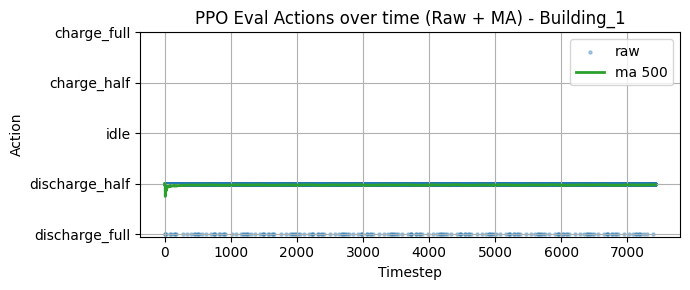

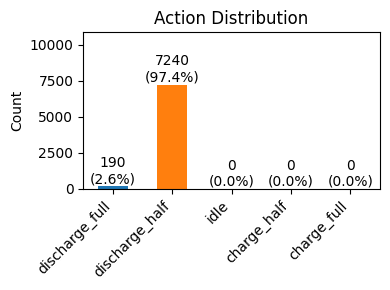

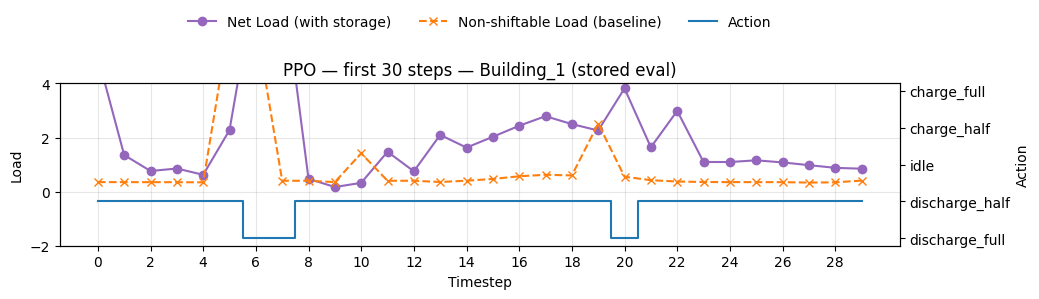

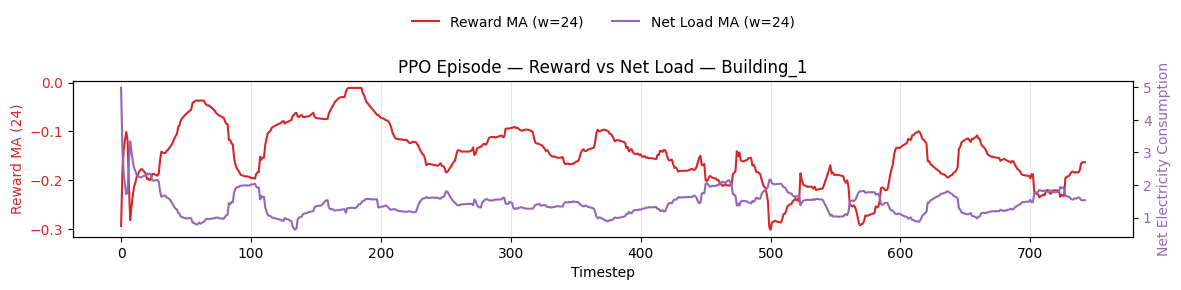

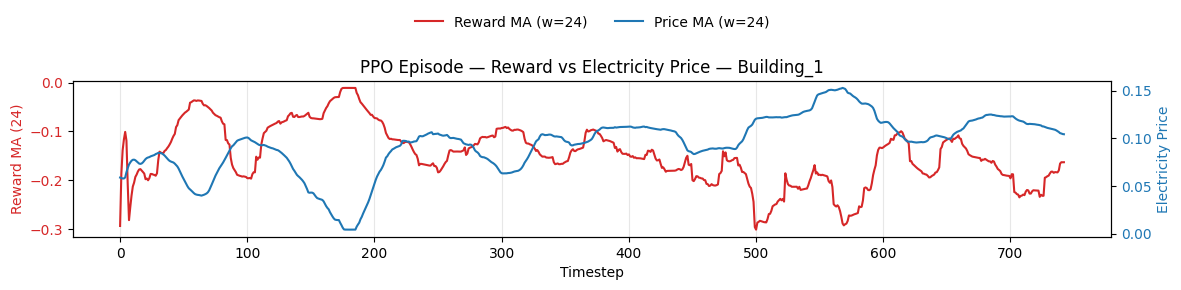

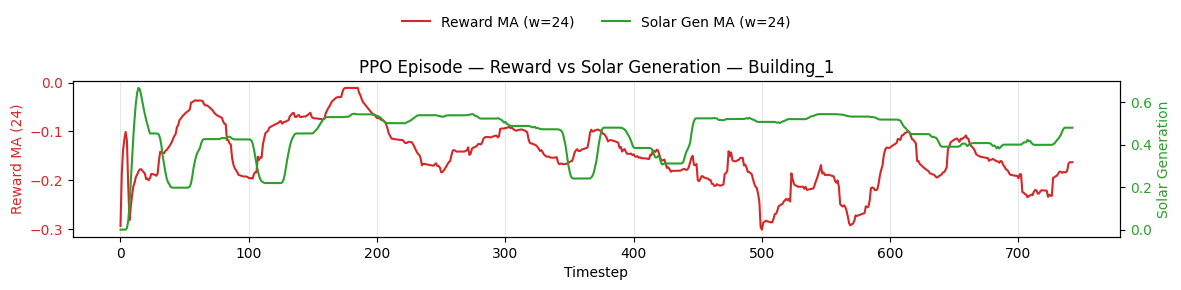

In [ ]:
from matplotlib.ticker import MultipleLocator

def _ensure_ppo_eval_results(path=EVAL_FILE):
    """Load eval results from eval file."""
    global er_ppo
    if os.path.exists(path):
        with open(path, "rb") as f:
            er_ppo = pickle.load(f)
        print(f"PPO eval results loaded from {os.path.abspath(path)}.")
        return er_ppo
    raise FileNotFoundError(f"{path} not found. Run evaluate_with_metrics(..., save_path=EVAL_FILE) first.")

# Load PPO eval
er = _ensure_ppo_eval_results()

# Rebuild actions_det and metrics_det from file
if 'ep_action_fracs' in er:
    actions_det = [np.asarray(ep, dtype=float)[:, None] for ep in er['ep_action_fracs']]
elif 'actions_disc_list' in er:
    actions_det = [INT_TO_FRAC[np.asarray(ep, dtype=int)][:, None] for ep in er['actions_disc_list']]
else:
    raise KeyError("No action sequences found in PPO eval results.")

metrics_det = er.get('metrics_df', None)
if metrics_det is None or not isinstance(metrics_det, pd.DataFrame):
    ep_lengths = np.asarray(er.get('ep_lengths', [len(x) for x in actions_det]), dtype=int)
    metrics_det = pd.DataFrame({'episode': np.arange(1, len(ep_lengths)+1), 'length': ep_lengths})

# Prefer building name from file if present
building_name = er.get('building_name', 'Building_1')

# Choose a building to visualize
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
actions_arr = np.concatenate(actions_det, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_det['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map continuous action to 5 RBC-like labels by nearest of [-1,-0.5,0,0.5,1]
bin_centers = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
def cont_to_label(vals):
    idx = np.argmin(np.abs(vals[..., None] - bin_centers[None, ...]), axis=-1)
    return idx  # 0..4

# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')
plt.title(f'PPO Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Timestep'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(ticks=INT_TO_FRAC.tolist(), labels=ACTION_LABELS)
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
plt.figure(figsize=(4,3))
labels_idx = cont_to_label(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

def capture_ep_series_ppo(building_name="Building_1", episode_idx=0, max_steps=None):
    """Build per-step DataFrame from saved PPO eval_results; no env stepping."""
    er = _ensure_ppo_eval_results()
    needed = ['ep_action_fracs','ep_rewards_list','ep_net_load','ep_non_shiftable_load','ep_price','ep_solar_generation']
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"ppo eval_results missing keys: {missing}. Re-run evaluate_with_metrics to regenerate.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    if 'actions_disc_list' in er and er['actions_disc_list'] and len(er['actions_disc_list']) > episode_idx:
        a_id = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    else:
        frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
        a_id = np.argmin(np.abs(frac[:, None] - INT_TO_FRAC[None, :]), axis=1)

    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = (
            a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]
        )
    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

def plot_first_30_steps_actions_vs_loads_ppo(building_name="Building_1", episode_idx=0):
    """Plot first 30 steps using stored eval."""
    df30, bname = capture_ep_series_ppo(building_name, episode_idx=episode_idx, max_steps=30)
    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)
    ax1.yaxis.set_major_locator(MultipleLocator(2))
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['discharge_full', 'discharge_half', 'idle', 'charge_half', 'charge_full'])
    add_top_legend(ax1, ax2)
    plt.title(f'PPO — first 30 steps — {bname} (stored eval)')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_ppo(building_name="Building_1", episode_idx=0):
    """Three plots using stored eval for selected episode."""
    df, bname = capture_ep_series_ppo(building_name, episode_idx=episode_idx, max_steps=None)
    window_reward = 24
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()

# ----- Plot 3: Actions vs Loads (first 30 steps) from file -----
plot_first_30_steps_actions_vs_loads_ppo(building_name=building_name, episode_idx=0)

# ----- Plot 4,5,6: Reward vs Observations (stored eval) -----
plot_ep1_reward_vs_obs_ppo(building_name=building_name, episode_idx=0)

##### View action distribution

In [ ]:
# Quick action-distribution sanity check (quantize to 5 bins)
er = _ensure_ppo_eval_results(path=EVAL_FILE)
if 'ep_action_fracs' in er:
    a = np.concatenate([np.asarray(ep) for ep in er['ep_action_fracs']])
    bins = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=float)
    idx = np.argmin(np.abs(a[:, None] - bins[None, :]), axis=1)
    dist = pd.Series(idx).value_counts().reindex(range(5)).fillna(0).astype(int)
    total = dist.sum()
    print('PPO action distribution (bin 0..4):', dist.to_dict())
    print('PPO action distribution pct:', {i: f'{int(v)} ({v/total:.1%})' for i,v in dist.items()})
else:
    print("No 'ep_action_fracs' in eval results; check evaluate_with_metrics output.")

PPO action distribution (bin 0..4): {0: 190, 1: 7240, 2: 0, 3: 0, 4: 0}
PPO action distribution pct: {0: '190 (2.6%)', 1: '7240 (97.4%)', 2: '0 (0.0%)', 3: '0 (0.0%)', 4: '0 (0.0%)'}


#### Cumulative Rewards

[-110.00718834 -110.00718834 -110.00718834 -110.00718834 -110.00718834
 -110.00718834 -110.00718834 -110.00718834 -110.00718834 -110.00718834]


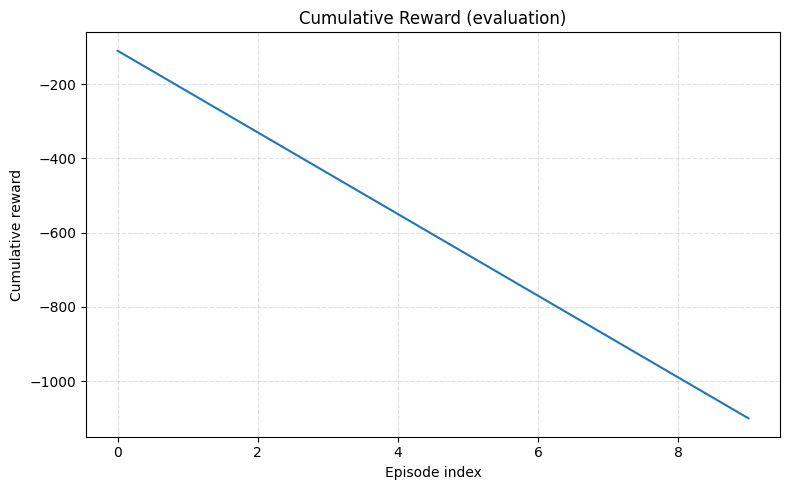

Episodes: 10 | Final cumulative reward: -1100.072


In [ ]:
# Plot cumulative reward from DQN eval .pkl
from pathlib import Path

p = Path(EVAL_FILE)
if not p.exists():
    raise FileNotFoundError(f"Eval file not found: {p.resolve()}")

with open(p, "rb") as f:
    data = pickle.load(f)

def to_1d_float_array(x):
    arr = np.asarray(x, dtype=float)
    return arr.ravel()

def extract_episode_returns(d):
    # Preferred: ep_rewards_list
    if isinstance(d, dict) and "ep_rewards_list" in d:
        ep = d["ep_rewards_list"]
        # ep can be: list[float] OR list[list[step_rewards]]/ndarrays
        if len(ep) == 0:
            return np.array([], dtype=float)
        first = ep[0]
        if isinstance(first, (list, tuple, np.ndarray)):
            # list of per-step rewards per episode -> sum each episode
            return np.array([np.sum(np.asarray(e, dtype=float)) for e in ep], dtype=float)
        else:
            # already per-episode returns
            return to_1d_float_array(ep)

    # Fallback: step_rewards segmented by ep_lengths
    if isinstance(d, dict) and "step_rewards" in d and "ep_lengths" in d:
        step_rewards = to_1d_float_array(d["step_rewards"])
        ep_lengths = np.asarray(d["ep_lengths"], dtype=int).ravel()
        if np.sum(ep_lengths) != step_rewards.size:
            raise ValueError(
                f"Mismatch: sum(ep_lengths)={np.sum(ep_lengths)} != len(step_rewards)={step_rewards.size}"
            )
        # segment
        offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
        returns = [step_rewards[o:o+l].sum() for o, l in zip(offsets, ep_lengths)]
        return np.asarray(returns, dtype=float)

    # 3) Very last resort: common keys
    for k in ["episode_rewards", "returns", "reward", "return"]:
        if isinstance(d, dict) and k in d:
            return to_1d_float_array(d[k])

    raise ValueError(
        "Could not extract per-episode returns. "
        "Expected 'ep_rewards_list' or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(d.keys()) if isinstance(d, dict) else type(d)}"
    )

episode_returns = extract_episode_returns(data)
print(episode_returns)
if episode_returns.size == 0:
    raise ValueError("No episodes found in eval results (empty returns).")

cumulative = np.cumsum(episode_returns)

plt.figure(figsize=(8, 5))
plt.plot(cumulative)
plt.xlabel("Episode index")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward (evaluation)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Episodes: {episode_returns.size} | Final cumulative reward: {cumulative[-1]:.3f}")

In [ ]:
# === Plot cumulative reward for one training episode ===

# Settings: which env/episode to plot?
ENV_ID = 0            # usually 0 with DummyVecEnv
EPISODE_IDX = 0       # -1 = last filled episode for this ENV_ID; otherwise 0,1,2,...

# Load CSV
csv_path = TRAIN_STEPS_FILE  # e.g., os.path.join(LOG_DIR, "ppo_train_steps_01.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"TRAIN_STEPS_FILE not found: {csv_path}")

df = pd.read_csv(csv_path)

# Robust: clean column dtypes
for col in ("reward", "env_id", "episode", "global_step"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
# Keep only valid rows
need_cols = [c for c in ("env_id", "episode", "reward") if c in df.columns]
df = df.dropna(subset=need_cols)

# Show episode overview per env
episodes_per_env = (
    df.groupby(["env_id", "episode"], as_index=False)["reward"]
      .size()
      .rename(columns={"size": "steps"})
      .sort_values(["env_id", "episode"])
)
print("Episodes available (per env):")
print(episodes_per_env.head(20))

# Select one episode
env_mask = (df["env_id"] == ENV_ID) if "env_id" in df.columns else np.ones(len(df), dtype=bool)
df_env = df.loc[env_mask].copy()
if "episode" not in df_env.columns:
    raise KeyError("CSV has no 'episode' column; cannot segment by episode.")

episodes = sorted(df_env["episode"].dropna().astype(int).unique())
if not episodes:
    raise ValueError(f"No episodes found for env_id={ENV_ID} in {csv_path}")

ep_chosen = episodes[EPISODE_IDX] if EPISODE_IDX != -1 else episodes[-1]
print(f"Plotting env_id={ENV_ID}, episode={ep_chosen}")

# Data of the selected episode in temporal order
order_cols = ["global_step"] if "global_step" in df_env.columns else None
df_ep = df_env.loc[df_env["episode"] == ep_chosen].copy()
if order_cols:
    df_ep = df_ep.sort_values(order_cols)

# Compute cumulative reward
df_ep["reward"] = pd.to_numeric(df_ep["reward"], errors="coerce").fillna(0.0)
df_ep["cum_reward"] = df_ep["reward"].cumsum()
df_ep["t_in_ep"] = np.arange(len(df_ep), dtype=int)

plt.figure(figsize=(9, 4.5))
plt.plot(df_ep["t_in_ep"], df_ep["cum_reward"], lw=2)
plt.title(f"Cumulative Reward — Training, episode {ep_chosen}")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(df_ep)} steps | Return: {df_ep['cum_reward'].iloc[-1]:.3f}")


# === Cumulative reward over timesteps for the first evaluation episode ===
assert 'EVAL_FILE' in globals(), "EVAL_FILE is not defined."
if not os.path.exists(EVAL_FILE):
    raise FileNotFoundError(f"Eval file not found: {os.path.abspath(EVAL_FILE)}")

with open(EVAL_FILE, "rb") as f:
    er = pickle.load(f)

def _as_1d_float(x):
    return np.asarray(x, dtype=float).ravel()

def first_episode_step_rewards(data):
    """
    Try common layouts produced by your notebooks:
      - 'ep_rewards_list': list of per-episode step-reward arrays/lists
      - ('step_rewards' + 'ep_lengths'): flat step rewards + per-episode lengths
    Returns: np.ndarray of step rewards for episode 0.
    """
    if isinstance(data, dict):
        # Preferred: list of per-episode step-reward sequences
        if "ep_rewards_list" in data and len(data["ep_rewards_list"]) > 0:
            ep0 = data["ep_rewards_list"][0]
            # Some pipelines store floats (already per-episode sum) -> then we can't do cumulative steps
            if isinstance(ep0, (list, tuple, np.ndarray)):
                return _as_1d_float(ep0)

        # Fallback: flat step_rewards segmented by ep_lengths
        if "step_rewards" in data and "ep_lengths" in data:
            step_rewards = _as_1d_float(data["step_rewards"])
            ep_lengths   = np.asarray(data["ep_lengths"], dtype=int).ravel()
            if ep_lengths.size == 0:
                raise ValueError("ep_lengths is empty in eval file.")
            L0 = int(ep_lengths[0])
            if L0 <= 0:
                raise ValueError(f"First episode length is non-positive: {L0}")
            if step_rewards.size < L0:
                raise ValueError(f"Not enough step rewards for first episode: have {step_rewards.size}, need {L0}")
            return step_rewards[:L0]

        # Some variants:
        for k in ("episode_step_rewards", "rewards_per_step", "ep0_step_rewards"):
            if k in data:
                return _as_1d_float(data[k])

    raise ValueError(
        "Could not find per-step rewards for episode 0 in EVAL_FILE. "
        "Expected 'ep_rewards_list' (list of per-step arrays) or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"
    )

# Extract per-step rewards for the first eval episode
r0 = first_episode_step_rewards(er)
cum0 = np.cumsum(r0)

plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(len(cum0)), cum0, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode 0 length: {len(r0)} steps | Return: {cum0[-1]:.3f}")

#### Obs Min Max

##### pricing

In [ ]:
# === Min/Max from pricing CSV ===
try:
    pricing_path = os.path.join(ROOT_DIR, PRICING_FILE)
except NameError:
    pricing_path = PRICING_FILE

if not os.path.exists(pricing_path):
    raise FileNotFoundError(f"Pricing file not found: {os.path.abspath(pricing_path)}")

df = pd.read_csv(pricing_path)

# Possible column names (adjust if needed)
candidates = [
    'electricity_pricing'
]
price_col = None
for c in candidates:
    if c in df.columns:
        price_col = c
        break
# If nothing matches, try to find a single numeric column
if price_col is None:
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(numeric_cols) == 1:
        price_col = numeric_cols[0]
    else:
        raise ValueError(f"Keine eindeutige Preis-Spalte gefunden. Spalten: {list(df.columns)}")

series = pd.to_numeric(df[price_col], errors='coerce').dropna()
print(f"Pricing file: {os.path.abspath(pricing_path)}")
print(f"Spalte: '{price_col}' | Werte: {len(series)}")

print(f"Min : {series.min():.6f}")
print(f"Max : {series.max():.6f}")
print(f"Mittelwert : {series.mean():.6f}")
print(f"Median     : {series.median():.6f}")

Pricing file: /hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/pricing_germany_2023_june_to_august.csv
Spalte: 'electricity_pricing' | Werte: 2208
Min : -0.500000
Max : 0.291930
Mittelwert : 0.088831
Median     : 0.094620


##### net_load

In [ ]:
# === Min/Max of net_load from TRAIN_STEPS_FILE ===
assert 'TRAIN_STEPS_FILE' in globals(), "TRAIN_STEPS_FILE ist nicht definiert."
if not os.path.exists(TRAIN_STEPS_FILE):
    raise FileNotFoundError(f"Datei nicht gefunden: {os.path.abspath(TRAIN_STEPS_FILE)}")

df = pd.read_csv(TRAIN_STEPS_FILE)

if 'net_load' not in df.columns:
    raise KeyError(f"'net_load' nicht in Spalten: {list(df.columns)[:10]} ...")

net = pd.to_numeric(df['net_load'], errors='coerce').dropna()

print(f"Datei: {os.path.abspath(TRAIN_STEPS_FILE)}")
print(f"Anzahl gültiger net_load-Werte: {len(net)}")
print(f"Min  : {net.min():.6f}")
print(f"Max  : {net.max():.6f}")
print(f"Mittelwert: {net.mean():.6f}")
print(f"Median    : {net.median():.6f}")

# Optional: print per env_id (if present)
if 'env_id' in df.columns:
    by_env = (pd.DataFrame({'net_load': net})
              .join(df.loc[net.index, 'env_id'].reset_index(drop=True))
              .groupby('env_id')['net_load'])
    print("\nPro env_id:")
    for eid, s in by_env:
        print(f"  env {eid}: min={s.min():.6f}, max={s.max():.6f}, n={s.size}")

Datei: /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
Anzahl gültiger net_load-Werte: 110400
Min  : -2.897844
Max  : 11.903888
Mittelwert: 1.217221
Median    : 0.974368

Pro env_id:
  env 0: min=-2.897844, max=11.903888, n=110400


##### reward

In [ ]:
# === Min/Max of reward from TRAIN_STEPS_FILE ===
assert 'TRAIN_STEPS_FILE' in globals(), "TRAIN_STEPS_FILE ist nicht definiert."
if not os.path.exists(TRAIN_STEPS_FILE):
    raise FileNotFoundError(f"Datei nicht gefunden: {os.path.abspath(TRAIN_STEPS_FILE)}")

df = pd.read_csv(TRAIN_STEPS_FILE)

if 'reward' not in df.columns:
    raise KeyError(f"'reward' nicht in Spalten: {list(df.columns)[:10]} ...")

rew = pd.to_numeric(df['reward'], errors='coerce').dropna()

print(f"Datei: {os.path.abspath(TRAIN_STEPS_FILE)}")
print(f"Anzahl gültiger reward-Werte: {len(rew)}")
print(f"Min  : {rew.min():.6f}")
print(f"Max  : {rew.max():.6f}")
print(f"Mittelwert: {rew.mean():.6f}")
print(f"Median    : {rew.median():.6f}")

# Optional: print per env_id (if present)
if 'env_id' in df.columns:
    by_env = (pd.DataFrame({'reward': rew})
              .join(df.loc[rew.index, 'env_id'].reset_index(drop=True))
              .groupby('env_id')['reward'])
    print("\nPro env_id:")
    for eid, s in by_env:
        print(f"  env {eid}: min={s.min():.6f}, max={s.max():.6f}, n={s.size}")


Datei: /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
Anzahl gültiger reward-Werte: 110400
Min  : -2.205978
Max  : 0.267832
Mittelwert: -0.119414
Median    : -0.084363

Pro env_id:
  env 0: min=-2.205978, max=0.267832, n=110400


##### non_shiftable_load

In [ ]:
# === Min/Max of non_shiftable_load from TRAIN_STEPS_FILE ===
assert 'TRAIN_STEPS_FILE' in globals(), "TRAIN_STEPS_FILE ist nicht definiert."
if not os.path.exists(TRAIN_STEPS_FILE):
    raise FileNotFoundError(f"Datei nicht gefunden: {os.path.abspath(TRAIN_STEPS_FILE)}")

df = pd.read_csv(TRAIN_STEPS_FILE)

if 'non_shiftable_load' not in df.columns:
    raise KeyError(f"'non_shiftable_load' nicht in Spalten: {list(df.columns)[:10]} ...")

stor = pd.to_numeric(df['non_shiftable_load'], errors='coerce').dropna()

print(f"Datei: {os.path.abspath(TRAIN_STEPS_FILE)}")
print(f"Anzahl gültiger non_shiftable_load-Werte: {len(stor)}")
print(f"Min  : {stor.min():.6f}")
print(f"Max  : {stor.max():.6f}")
print(f"Mittelwert: {stor.mean():.6f}")
print(f"Median    : {stor.median():.6f}")

# Optional: print per env_id (if present)
if 'env_id' in df.columns:
    by_env = (pd.DataFrame({'non_shiftable_load': stor})
              .join(df.loc[stor.index, 'env_id'].reset_index(drop=True))
              .groupby('env_id')['non_shiftable_load'])
    print("\nPro env_id:")
    for eid, s in by_env:
        print(f"  env {eid}: min={s.min():.6f}, max={s.max():.6f}, n={s.size}")

Datei: /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
Anzahl gültiger non_shiftable_load-Werte: 110400
Min  : 0.000000
Max  : 7.458969
Mittelwert: 0.597131
Median    : 0.403018

Pro env_id:
  env 0: min=0.000000, max=7.458969, n=110400


#### Heatmap

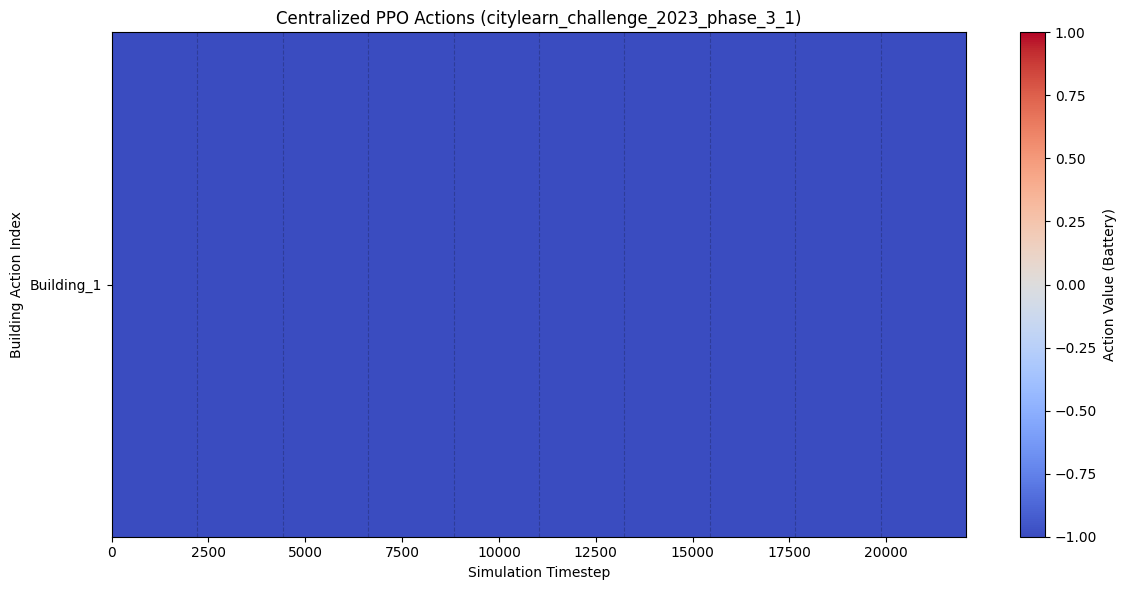

In [ ]:
# Heatmap of PPO actions across buildings and timesteps (eval episodes concatenated)

# Require evaluated actions
assert 'actions_det' in globals() and len(actions_det) > 0, "Run evaluate_with_metrics first."

# Flatten list[(ep_len, n_actions)] -> (total_steps, n_actions)
actions_arr = np.concatenate(actions_det, axis=0)
n_steps, n_actions = actions_arr.shape

# Episode boundaries for vertical lines
ep_lengths = metrics_det['length'].to_numpy() if 'metrics_det' in globals() else np.array([n_steps])
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))

# Building labels
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if len(bld_names) != n_actions:
    bld_names = [f'Act {i}' for i in range(n_actions)]

# Output dir
results_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(results_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.imshow(actions_arr.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.yticks(np.arange(n_actions), bld_names)

# Mark episode boundaries
for off in ep_offsets[1:]:
    plt.axvline(off, color='k', ls='--', lw=0.8, alpha=0.2)

plt.title(f'Centralized PPO Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ppo_actions_heatmap.png'), dpi=150)
plt.show()

#### DecisionTree

Loaded 110400 rows from /hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_train_steps_01.csv
n_features: 11 sample: ['battery_energy_balance', 'battery_soc', 'chargers_load', 'cooling_load', 'dhw_load', 'heating_load', 'net_load', 'non_shiftable_load', 'price', 'solar']
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best balanced_accuracy: 0.6642622750616047
Best params: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Surrogate Tree Accuracy: 0.542
Confusion matrix (rows=true, cols=pred):
 [[1692 6028  278    2    0]
 [ 534 8750  405    2    0]
 [   0 5288 2091    4    0]
 [   0    1   13 1394   71]
 [   0    0   11    4 1032]]
                precision    recall  f1-score   support

discharge_full       0.76      0.21      0.33      8000
discharge_half       0.44      0.90      0.59      9691
          idle       0.75      0.28      0.41      7383
   charge_half       0.99 

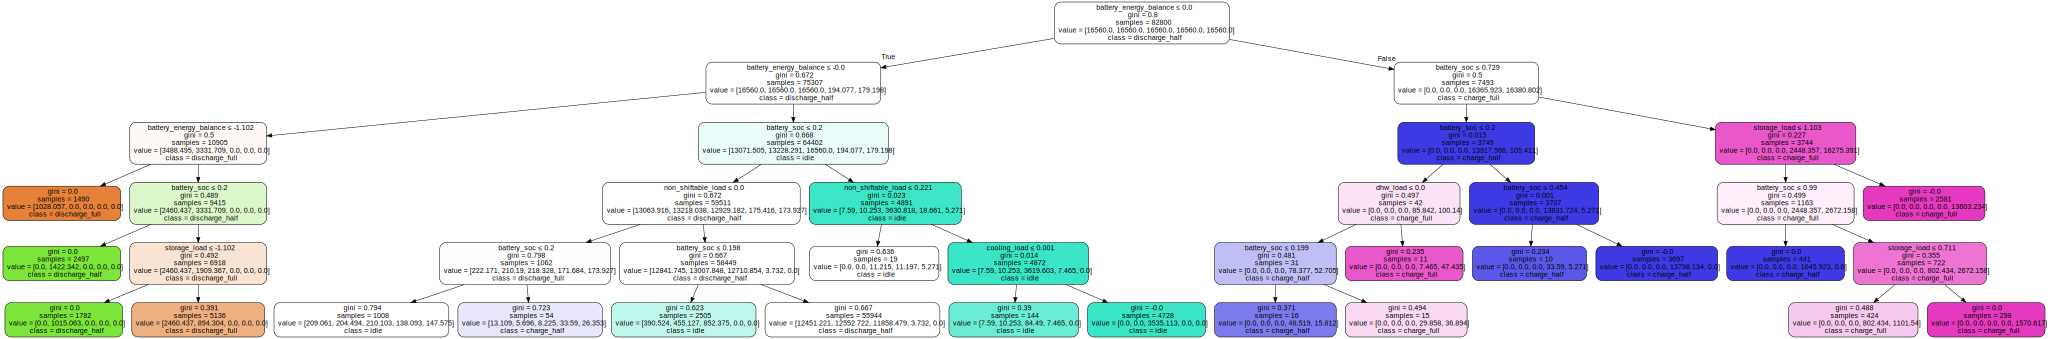

In [ ]:
# ---- Explainability (PPO): Decision Tree (state -> action) ----
# Trains a small surrogate tree (Observation -> chosen discrete action)
# and visualizes it. Works with your PPO training logs.

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------- Load dataset ----------
def _load_policy_dataset():
    csv_path = TRAIN_STEPS_FILE 
    if csv_path and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows from {os.path.abspath(csv_path)}")
        return df
    # Fallback: in-memory callback
    if 'train_callback' in globals() and hasattr(train_callback, 'df') and train_callback.df is not None and len(train_callback.df):
        print("Using in-memory train_callback.df")
        return train_callback.df.copy()
    raise FileNotFoundError("No training dataset found. Set TRAIN_STEPS_FILE or ensure ppo_train_steps_*.csv exists.")

df_steps = _load_policy_dataset()

# ---------- Prepare features & label ----------
target_col = "action_id"  # PPO logs discrete ID (0..4)
if target_col not in df_steps.columns:
    # some logs name the column just 'action'
    if 'action' in df_steps.columns:
        df_steps[target_col] = df_steps['action'].astype(int)
    else:
        raise KeyError(f"Target column '{target_col}' not found in df.")

# Columns we DEFINITELY do NOT want to use as features (leaks/meta)
explicit_drop = {
    "global_step", "env_id", "episode",
    "action_id", "action", "action_label", "action_frac",
    "reward", "done"
}
# additionally drop anything obviously related to action/reward
leak_prefixes = ("action", "reward", "done", "adv", "return", "value")

num_bool_cols = df_steps.select_dtypes(include=[np.number, bool]).columns
feat_cols = []
for c in num_bool_cols:
    if c in explicit_drop: 
        continue
    if c == target_col:
        continue
    if any(c.startswith(p) for p in leak_prefixes):
        continue
    feat_cols.append(c)

feat_cols = sorted(feat_cols, key=lambda x: x)
assert len(feat_cols) > 0, f"No features selected – check your dataframe columns! (numeric cols: {list(num_bool_cols)[:10]})"
print("n_features:", len(feat_cols), "sample:", feat_cols[:10])

feature_names = list(feat_cols)
X = df_steps[feat_cols].to_numpy()
y = df_steps[target_col].astype(int).to_numpy()

# Train/test split with stratify to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# ---------- Train decision tree (GridSearch) ----------
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5],
    "min_samples_leaf": [1, 5, 10],
    "min_samples_split": [2, 5, 10],
    "class_weight": ["balanced"],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "splitter": ["best"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
print("Best balanced_accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

clf = grid.best_estimator_

# ---------- Report quality ----------
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Surrogate Tree Accuracy: {acc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))

# Class names: ACTION_LABELS if available, otherwise derive from INT_TO_FRAC
if 'ACTION_LABELS' in globals() and isinstance(ACTION_LABELS, (list, tuple)) and len(ACTION_LABELS) >= (int(np.max(y))+1):
    class_names = ACTION_LABELS
else:
    if 'INT_TO_FRAC' in globals():
        # map [-1,-0.5,0,0.5,1] to labels
        frac = [str(v) for v in list(INT_TO_FRAC)]
        # nicer defaults:
        mapping = { -1.0:"discharge_full", -0.5:"discharge_half", 0.0:"idle", 0.5:"charge_half", 1.0:"charge_full" }
        class_names = [mapping.get(float(INT_TO_FRAC[i]), frac[i]) for i in range(int(np.max(y))+1)]
    else:
        class_names = [str(i) for i in range(int(np.max(y))+1)]

print(classification_report(y_test, y_pred, target_names=class_names))

# ---------- Global explanations ----------
print("\nTop feature importances:")
imp = clf.feature_importances_
assert len(imp) == len(feature_names), "Mismatch between importances and feature names."
imp_idx = np.argsort(imp)[::-1]
for i in imp_idx[:10]:
    if imp[i] <= 0: break
    print(f"- {feature_names[i]}: {imp[i]:.4f}")

# ---------- Local explanation ----------
def explain_sample(idx_in_df: int):
    """Print the decision path for a given row from df_steps."""
    x = df_steps.iloc[idx_in_df][feat_cols].to_numpy().reshape(1, -1)
    true_a = int(df_steps.iloc[idx_in_df][target_col])
    pred_a = int(clf.predict(x)[0])
    proba  = clf.predict_proba(x)[0]
    tree = clf.tree_
    node = 0
    path = []
    while tree.feature[node] != -2:  # -2 => leaf
        f_idx = tree.feature[node]
        thr = tree.threshold[node]
        val = float(x[0, f_idx])
        go_left = val <= thr
        path.append((feature_names[f_idx], val, thr, "left" if go_left else "right"))
        node = tree.children_left[node] if go_left else tree.children_right[node]
    def _label(a):
        try:
            return class_names[a]
        except Exception:
            return str(a)
    print(f"True action: {true_a} ({_label(true_a)}), Pred: {pred_a} ({_label(pred_a)})")
    print("Proba:", {class_names[i]: float(f"{p:.3f}") for i,p in enumerate(proba)})
    print("Decision path:")
    for name, val, thr, side in path:
        print(f" - {name}: {val:.4f} <= {thr:.4f} -> {side}")
    return pred_a

# Example: random dataset index
_ = explain_sample(idx_in_df=np.random.randint(0, len(df_steps)))

# ---------- Visualization ----------
try:
    from sklearn.tree import export_graphviz
    import graphviz
    from IPython.display import SVG, display

    dot = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    src = graphviz.Source(dot)
    display(SVG(src.pipe(format='svg')))  # crisp, scalable
except Exception as e:
    print("Graphviz unavailable; fallback to matplotlib. Error:", e)
    plt.figure(figsize=(32, 16), dpi=250)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        max_depth=4,
        fontsize=14
    )
    plt.tight_layout()
    plt.show()
